In [1]:
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.init import xavier_normal_
from torch.utils.data import DataLoader, Dataset, random_split
from torch.autograd import Variable, Function
from torch.nn.parameter import Parameter

import random

from sklearn.metrics import mean_squared_error
from numpy.linalg import solve
from scipy.sparse import csr_matrix

import numpy as np
import pandas as pd
from numba import jit

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time
from timeit import default_timer as timer

from general_functions1 import sqrt_err_relative, check_coo_tensor, gen_coo_tensor
import evaluation_functions as ef

from t_alg import mttcrp, mttcrp1, get_elem_deriv_tensor, factors_to_tensor
from t_alg import gcp_grad, multi_ind_to_indices, indices_to_multi_ind

from samplings import give_ns, generate_data
from elementwise_grads import bernoulli_logit_loss, bernoulli_logit_loss_grad

%matplotlib inline

## Load the data:

In [2]:
path_data = "/notebook/Relations_Learning/Link_Prediction_Data/FB15K237/"
entity_list = pickle.load(open(path_data + 'entity_list', 'rb'))
relation_list = pickle.load(open(path_data + 'relation_list', 'rb'))

train_triples = pickle.load(open(path_data + 'train_triples', 'rb'))
valid_triples = pickle.load(open(path_data + 'valid_triples', 'rb'))
test_triples = pickle.load(open(path_data + 'test_triples', 'rb'))
train_valid_triples = pickle.load(open(path_data + 'train_valid_triples', 'rb'))

entity_map = pickle.load(open(path_data + 'entity_map', 'rb'))
relation_map = pickle.load(open(path_data + 'relation_map', 'rb'))

all_triples = train_valid_triples + test_triples

In [3]:
%%time
sample_positive = ef.create_filter(train_triples)
ft = ef.create_filter(all_triples)

CPU times: user 641 ms, sys: 8.39 ms, total: 649 ms
Wall time: 648 ms


In [4]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.int64)

coords = np.array(train_triples, dtype=np.int64)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))

print(f"KG shape (sub., rel., obj.): {data_shape};\nNum train samples: {values.shape};")

KG shape (sub., rel., obj.): (14541, 237, 14541);
Num train samples: (272115,);


In [5]:
class WARP(Function): 
    '''
    autograd function of WARP loss
    '''
    @staticmethod
    def forward(ctx, input, target, max_num_trials=None):
        
        batch_size = target.size()[0]
        if max_num_trials is None: 
            max_num_trials = target.size()[1] - 1
        
        positive_indices = torch.zeros(input.size(), device=device)
        negative_indices = torch.zeros(input.size(), device=device)
        L = torch.zeros(input.size()[0], device=device)
        
        all_labels_idx = np.arange(target.size()[1])
        
        Y = float(target.size()[1])
        J = torch.nonzero(target)
        
        for i in range(batch_size): 
            
            msk = np.ones(target.size()[1], dtype = bool)
            
            # For i user in batch choose ONE item!
            msk_J = J[:, 0] == i
            indice = np.random.choice(np.arange(J[msk_J].shape[0]), 1)
            #J[msk_J][indice].squeeze()[1]
            
            # Find the positive label for this example
            j = J[msk_J][indice].squeeze()[1]
            positive_indices[i, j] = 1
            msk[j] = False
            
            # initialize the sample_score_margin
            sample_score_margin = -1
            num_trials = 0
            
            neg_labels_idx = all_labels_idx[msk]

            while ((sample_score_margin < 0) and (num_trials < max_num_trials)):
                 
                #randomly sample a negative label
                neg_idx = np.random.choice(neg_labels_idx, 1)[0]
                msk[neg_idx] = False
                neg_labels_idx = all_labels_idx[msk]
                
                num_trials += 1
                # calculate the score margin 
                sample_score_margin = 1 + input[i, neg_idx] - input[i, j] 
            
            if sample_score_margin < 0:
                # checks if no violating examples have been found 
                continue
            else: 
                loss_weight = np.log(np.floor((Y-1)/(num_trials)))
                L[i] = loss_weight
                negative_indices[i, neg_idx] = 1
        
        loss = L * (
            1 - torch.sum(positive_indices*input, dim = 1) 
            + torch.sum(negative_indices*input, dim = 1)
        )
        
        ctx.save_for_backward(input, target)
        ctx.L = L
        ctx.positive_indices = positive_indices
        ctx.negative_indices = negative_indices
        
        return torch.sum(loss , dim = 0, keepdim = True)

    # This function has only a single output, so it gets only one gradient 
    @staticmethod
    def backward(ctx, grad_output):
        input, target = ctx.saved_tensors
        L = Variable(torch.unsqueeze(ctx.L, 1), requires_grad = False)

        positive_indices = Variable(ctx.positive_indices, requires_grad = False) 
        negative_indices = Variable(ctx.negative_indices, requires_grad = False)
        grad_input = grad_output * L * (negative_indices - positive_indices)

        return grad_input, None, None    

      
class WARPLoss(nn.Module): 
    def __init__(self, max_num_trials = None): 
        super(WARPLoss, self).__init__()
        self.max_num_trials = max_num_trials
        
    def forward(self, input, target): 
        return WARP.apply(input, target, self.max_num_trials)

In [6]:
# Define model:
class GCP_WARP(torch.nn.Module):
    def __init__(self, n_entity, n_relation, n_factors=200, device='cpu'):
        super(GCP_WARP, self).__init__()
        
        # Objects and Subjects are represented as entity_factors:
        self.entity_factors = Parameter(
            torch.randn(n_entity, n_factors),
        )
        xavier_normal_(self.entity_factors)
        
        # Relations between the two entities:
        self.relations_factors = Parameter(
            torch.randn(n_relation, n_factors),
        )
        xavier_normal_(self.relations_factors)    
    
    def forward(self, subjects, relations, objects):
        # subjects, relations, objects - are indices
        
        pred = torch.sum(
            (self.entity_factors[subjects] 
            * self.relations_factors[relations]
            * self.entity_factors[objects]),
            dim=1,
        )
        return pred   

dat = np.random.randn(20000, 14000)
torch.topk(torch.tensor(dat), 10, dim=1)[1]

In [7]:
n_entity = data_shape[0]
n_relation = data_shape[1]
n_factors = 200
device = torch.device("cuda:1")

model = GCP_WARP(n_entity, n_relation, n_factors, device=device).to(device)
print(model)

GCP_WARP()


In [8]:
def train_batch_warp(train_data, data_shape, sample_positive, model,
                     loss_fn, optimizer, un_pair, bs=64,
                     show=True, device='cpu'):

    user_idx = np.arange(len(un_pair))
    np.random.shuffle(user_idx)
    batches = np.array_split(user_idx, train_data.shape[0] // bs)
    cols = torch.arange(data_shape[2])
    
    for i, batch in enumerate(batches):
        rows = torch.tensor(batch)

        # Compute prediction error
        rating = torch.zeros((len(un_pair[rows]), data_shape[2])).to(device)
        for j in range(rating.shape[0]):
            rating[j][sample_positive[tuple(un_pair[rows][j].tolist())]] = 1.0

        prediction = model(
            torch.repeat_interleave(torch.tensor(un_pair[rows][:, 0]), cols.shape[0]),
            torch.repeat_interleave(torch.tensor(un_pair[rows][:, 1]), cols.shape[0]),
            torch.tile(cols, (un_pair[rows].shape[0], )),
        ).view(un_pair[rows].shape[0], cols.shape[0]).to(torch.float64)

        loss = loss_fn(prediction, rating)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if show and (i % 10 == 0):
            loss, current = loss.item(), i * len(rows)
            print(f"loss: {loss:>7f}  [{current:>5d}/{coords.shape[0]:>5d}]")

In [9]:
epochs = 30

optimizer = optim.Adam(model.parameters(), lr=5e-4)
#optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=1e-2)
loss_fn = WARPLoss(20)
un_pair = np.array(list(sample_positive.keys()))
batch_size = 64
show = False
device = torch.device("cuda:1")
hr_k = (1, 3, 10)

In [10]:
res = []
for epoch in range(epochs):
    
    start = time.time()
    train_batch_warp(
        train_data=coords,
        data_shape=data_shape,
        sample_positive=sample_positive,
        model=model,
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        un_pair=un_pair, 
        bs=batch_size,
        show=show,
        device=device,
    )
    end = time.time() - start
    
    if epoch % 2 == 0: 
        a = model.entity_factors.cpu().detach().numpy()
        b = model.relations_factors.cpu().detach().numpy()
        c = model.entity_factors.cpu().detach().numpy()
        
        start = time.time()
        hr_result = ef.hr(ft, valid_triples, a, b, c, hr_k)
        end_hr = time.time() - start
        print(f"\nEpoch {epoch + 1}: HR{hr_k}, MRR: {hr_result}; Time: {end:.2}, {end_hr:.2}")
        res.append(hr_result)
print("\nDone!")


Epoch 1: HR(1, 3, 10), MRR: [0.17867123 0.25463359 0.34992871 0.22838145]; Time: 2.4e+02, 3.5

Epoch 3: HR(1, 3, 10), MRR: [0.20815512 0.29472484 0.41123467 0.26575006]; Time: 3.7e+02, 3.4

Epoch 5: HR(1, 3, 10), MRR: [0.22309666 0.31400057 0.44060451 0.28447954]; Time: 4e+02, 3.4

Epoch 7: HR(1, 3, 10), MRR: [0.22560593 0.32820074 0.45919589 0.29295142]; Time: 4.2e+02, 3.5

Epoch 9: HR(1, 3, 10), MRR: [0.23666952 0.34171657 0.47179926 0.30511897]; Time: 4.3e+02, 3.5

Epoch 11: HR(1, 3, 10), MRR: [0.2386085  0.34770459 0.47909894 0.3080371 ]; Time: 4.3e+02, 3.5

Epoch 13: HR(1, 3, 10), MRR: [0.24100371 0.34810379 0.48645566 0.31158015]; Time: 4.4e+02, 3.5

Epoch 15: HR(1, 3, 10), MRR: [0.2423724  0.35500428 0.49250071 0.31479626]; Time: 4.4e+02, 3.5

Epoch 17: HR(1, 3, 10), MRR: [0.24248646 0.3546621  0.49147419 0.3151812 ]; Time: 4.4e+02, 3.5

Epoch 19: HR(1, 3, 10), MRR: [0.24944397 0.36578272 0.4956373  0.32199981]; Time: 4.4e+02, 3.5

Epoch 21: HR(1, 3, 10), MRR: [0.24932991 0.368

In [ ]:
with open('gcp_warp_hr.pickle', 'wb') as f:
     pickle.dump(res, f)

In [2]:
with open('gcp_warp_hr.pickle', 'rb') as f:
     res = pickle.load(f)

In [9]:
hr_10 = [res[i][2] for i in range(15)]
mrr_10 = [res[i][3] for i in range(15)]

Text(0.5, 1.0, 'FB15k-237')

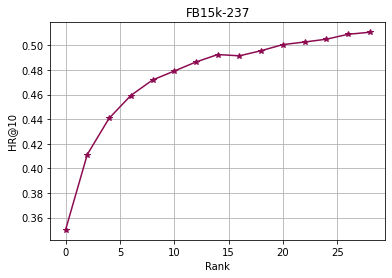

In [12]:
color = "#8b0a50"
plt.plot(
    list(range(0, 30, 2)),
    hr_10,
    '-*', c=color,
)

plt.grid()
plt.xlabel('Rank')
plt.ylabel('HR@10')
plt.title("FB15k-237")

Text(0.5, 1.0, 'FB15k-237')

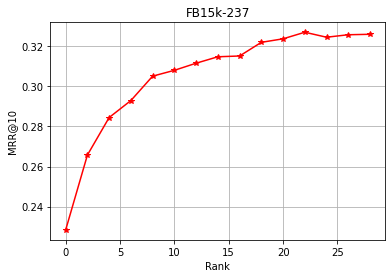

In [13]:
color = "red"
plt.plot(
    list(range(0, 30, 2)),
    mrr_10,
    '-*', c=color,
)

plt.grid()
plt.xlabel('Rank')
plt.ylabel('MRR@10')
plt.title("FB15k-237")